In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Specify stock symbol and date range
stock_symbol = 'AAPL'

# Fetch historical stock data
stock_data = yf.download(stock_symbol,  period="max")


# Code snippet for data preprocessing
closing_prices = stock_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

2024-12-04 08:21:31.643406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 08:21:31.939833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 08:21:32.300127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733311292.664596   45941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733311292.758493   45941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 08:21:33.340064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Define the prepare_data function
def prepare_data(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(x), np.array(y)

def create_lstm_model(input_shape):
    """
    Create and compile an LSTM model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data in the form (time_steps, features).

    Returns:
    - model (Sequential): Compiled LSTM model.
    """
    model = Sequential()
    # Add the first LSTM layer with 50 units and return sequences for the next layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    # Add the second LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add a Dense layer with 1 unit for regression
    model.add(Dense(units=1))
    
    # Compile the model using the Adam optimizer and Mean Squared Error loss
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


# Code snippet for creating and training the LSTM model
n_steps = 60

# Prepare the training data using the defined function
x_train, y_train = prepare_data(closing_prices_scaled, n_steps)

# Reshape the input data to fit the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create an instance of the LSTM model
model = create_lstm_model((x_train.shape[1], 1))

# Train the model on the training data
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2024-12-04 08:28:45.872062: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/aleksandro/Documentos/tc-fase-4/tech_challenge_lstm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 0.0018
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 1.1632e-04
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 8.9102e-05
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 6.0582e-05
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 5.8360e-05
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 5.3110e-05
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.6417e-05
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 6.7582e-05
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 3.9206e-05
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.7270e-05


In [3]:
# Code snippet for making predictions and evaluation
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)
mse = mean_squared_error(closing_prices[n_steps:], train_predictions)
print(f'Mean Squared Error on Training Data: {mse}')

345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Mean Squared Error on Training Data: 1.6198427647267097


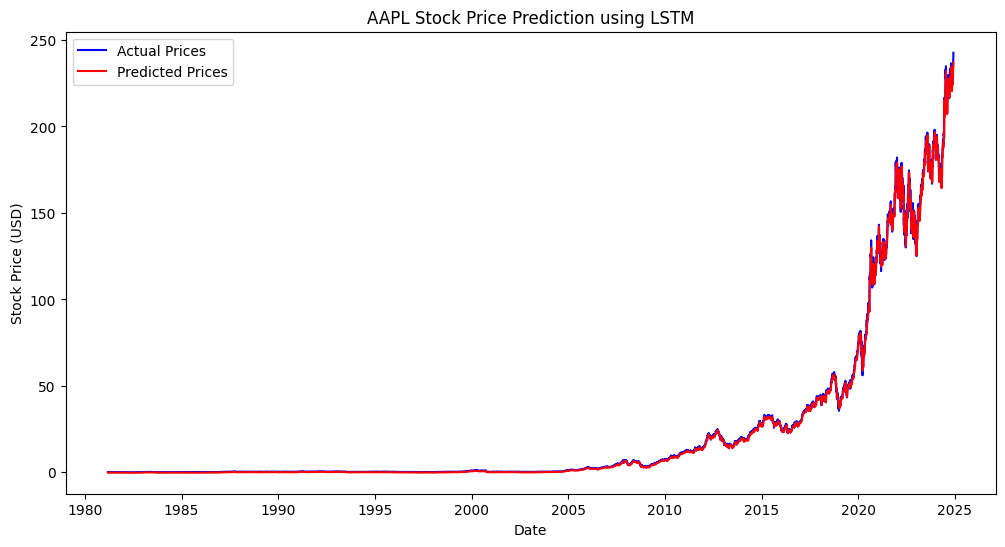

In [4]:
# Code snippet for plotting results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[n_steps:], closing_prices[n_steps:], label='Actual Prices', color='blue')
plt.plot(stock_data.index[n_steps:], train_predictions, label='Predicted Prices', color='red')
plt.title(f'{stock_symbol} Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [7]:
#https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95
#https://medium.com/@deepml1818/implementing-time-series-stock-price-prediction-with-lstm-and-yfinance-in-python-a769a3fe9a7b
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-01-01'
data = yf.download(stock_symbol, start=start_date, end=end_date)

close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

def create_lstm_data(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    
    return np.array(x), np.array(y)

time_steps = 10
x, y = create_lstm_data(close_prices_scaled, time_steps)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x, y, epochs=50, batch_size=32)


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/home/aleksandro/Documentos/tc-fase-4/tech_challenge_lstm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2526
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0261
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

In [20]:
future_dates = pd.date_range(start=end_date, periods=30)
last_prices = close_prices[-time_steps:]
last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1))
x_pred = np.array([last_prices_scaled[-time_steps:, 0]])
x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
predicted_prices_scaled = model.predict(x_pred)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

# future_data = pd.DataFrame({'Date': future_dates, 'Predicted Price': predicted_prices.flatten()})
# print(future_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [28]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [29]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

TensorFlow Version:  2.18.0


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_45941/4230465103.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_data.fillna(method='ffill', inplace=True)


In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])
    

In [38]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [39]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))


/home/aleksandro/Documentos/tc-fase-4/tech_challenge_lstm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

AttributeError: The layer sequential_3 has never been called and thus has no defined output.

In [35]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [ ]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq


In [42]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


[*********************100%***********************]  1 of 1 completed

TensorFlow Version:  2.18.0



/tmp/ipykernel_45941/372414117.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_data.fillna(method='ffill', inplace=True)
/home/aleksandro/Documentos/tc-fase-4/tech_challenge_lstm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.1304 - val_loss: 0.0041
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84m

In [45]:
from fastapi import FastAPI
from pydantic import BaseModel
from keras.models import load_model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

app = FastAPI()

# Carregar o modelo treinado
model = load_model("../model/lstm_stock_model_best.h5")

# Instanciar o scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Modelo de dados de entrada
class StockData(BaseModel):
    stock_symbol: str
    start_date: str
    end_date: str
    days_ahead: int = 10  # Definindo padrão para 10 dias


# Função para preparar os dados
def prepare_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    closing_prices = data["Close"].values.reshape(-1, 1)
    return closing_prices


# Rota de previsão
@app.post("/predict/")
async def predict(stock_data: StockData):
    closing_prices = prepare_data(
        stock_data.stock_symbol,
        stock_data.start_date,
        stock_data.end_date,
    )

    # Normalizar os dados
    scaled_data = scaler.fit_transform(closing_prices)

    # Últimos dados para iniciar as previsões
    input_sequence = scaled_data[-3:].reshape(1, 3, 1)  # Assume que a LSTM usa uma sequência de 3 timesteps

    predictions = []

    for i in range(stock_data.days_ahead):
        # Realiza a predição
        prediction = model.predict(input_sequence)

        # Inversão para o valor original
        prediction_original = scaler.inverse_transform(prediction)[0, 0]
        predictions.append(prediction_original)

        # Adiciona a previsão atual na sequência para a próxima previsão
        new_input = np.append(input_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
        input_sequence = new_input

    # Retorna a lista de previsões
    return {"predictions": predictions}


In [51]:
closing_prices = prepare_data('AAPL',"2023-01-01","2023-12-01")

# Normalizar os dados
scaled_data = scaler.fit_transform(closing_prices)

# Últimos dados para iniciar as previsões
input_sequence = scaled_data[-3:].reshape(1, 3, 1)  # Assume que a LSTM usa uma sequência de 3 timesteps

predictions = []

for i in range(10):
    # Realiza a predição
    prediction = model.predict(input_sequence)

    # Inversão para o valor original
    prediction_original = scaler.inverse_transform(prediction)[0, 0]
    predictions.append(prediction_original)

    # Adiciona a previsão atual na sequência para a próxima previsão
    new_input = np.append(input_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
    input_sequence = new_input

list(predictions)


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[np.float32(146.88538),
 np.float32(143.60931),
 np.float32(138.81482),
 np.float32(133.12602),
 np.float32(131.96529),
 np.float32(130.84459),
 np.float32(130.06175),
 np.float32(129.79256),
 np.float32(129.58798),
 np.float32(129.46947)]

In [50]:
list(predictions)

[np.float32(146.88538),
 np.float32(143.60931),
 np.float32(138.81482),
 np.float32(133.12602),
 np.float32(131.96529),
 np.float32(130.84459),
 np.float32(130.06175),
 np.float32(129.79256),
 np.float32(129.58798),
 np.float32(129.46947)]

In [48]:
{"predictions": predictions}

{'predictions': [np.float32(146.88538),
  np.float32(143.60931),
  np.float32(138.81482),
  np.float32(133.12602),
  np.float32(131.96529),
  np.float32(130.84459),
  np.float32(130.06175),
  np.float32(129.79256),
  np.float32(129.58798),
  np.float32(129.46947)]}

In [52]:
from fastapi import FastAPI
from pydantic import BaseModel
from keras.models import load_model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

app = FastAPI()

# Carregar o modelo treinado
model = load_model("../model/lstm_stock_model_best.h5")

# Instanciar o scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Modelo de dados de entrada
class StockData(BaseModel):
    stock_symbol: str
    start_date: str
    end_date: str
    days_ahead: int = 10  # Padrão de 10 dias


# Função para preparar os dados
def prepare_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    closing_prices = data["Close"].values.reshape(-1, 1)
    return closing_prices


# # Rota de previsão
# @app.post("/predict/")
# async def predict(stock_data: StockData):
#     closing_prices = prepare_data(
#         stock_data.stock_symbol,
#         stock_data.start_date,
#         stock_data.end_date,
#     )

#     # Normalizar os dados
#     scaled_data = scaler.fit_transform(closing_prices)

#     # Últimos dados para iniciar as previsões
#     input_sequence = scaled_data[-3:].reshape(1, 3, 1)  # Assume que a LSTM usa uma sequência de 3 timesteps

#     predictions = []

#     for i in range(stock_data.days_ahead):
#         # Realiza a predição
#         prediction = model.predict(input_sequence)

#         # Inversão para o valor original e conversão para float
#         prediction_original = float(scaler.inverse_transform(prediction)[0, 0])
#         predictions.append(prediction_original)

#         # Adiciona a previsão atual na sequência para a próxima previsão
#         new_input = np.append(input_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
#         input_sequence = new_input

#     # Retorna a lista de previsões como JSON serializável
#     return {"predictions": predictions}


In [54]:
closing_prices = prepare_data('AAPL',"2023-01-01","2023-12-01")

# Normalizar os dados
scaled_data = scaler.fit_transform(closing_prices)

# Últimos dados para iniciar as previsões
input_sequence = scaled_data[-3:].reshape(1, 3, 1)  # Assume que a LSTM usa uma sequência de 3 timesteps

predictions = []

for i in range(10):
    # Realiza a predição
    prediction = model.predict(input_sequence)

    # Inversão para o valor original e conversão para float
    prediction_original = float(scaler.inverse_transform(prediction)[0, 0])
    predictions.append(prediction_original)

    # Adiciona a previsão atual na sequência para a próxima previsão
    new_input = np.append(input_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
    input_sequence = new_input

# Retorna a lista de previsões como JSON serializável
{"predictions": predictions}

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


{'predictions': [146.8853759765625,
  143.60931396484375,
  138.8148193359375,
  133.1260223388672,
  131.9652862548828,
  130.84458923339844,
  130.06175231933594,
  129.7925567626953,
  129.58798217773438,
  129.46946716308594]}

# Projeto de Previsão de Preços de Ações com LSTM e FastAPI

Este projeto utiliza redes neurais LSTM (Long Short-Term Memory) para prever o valor de fechamento de ações com base em dados históricos. A solução é dividida em duas partes principais:
1. **Treinamento do Modelo LSTM**: Utiliza dados históricos de ações para treinar o modelo.
2. **API FastAPI**: Permite que os usuários façam previsões de preços de ações via uma API RESTful.

A solução é containerizada usando Docker, com o servidor **MLflow** para rastreamento de experimentos e gerenciamento de modelos.

---

## Funcionalidades do Projeto LSTM para Previsão de Ações

### 1. **Coleta e Pré-processamento de Dados**
   - Utiliza a biblioteca **`yfinance`** para obter dados históricos de ações.
   - Realiza limpeza e transformação dos dados, incluindo normalização.

### 2. **Treinamento do Modelo LSTM**
   - Implementa uma rede neural **LSTM** para previsão de valores de fechamento das ações.
   - Inclui ajuste de hiperparâmetros para otimizar o desempenho.

### 3. **Validação e Avaliação do Modelo**
   - Avalia o modelo com métricas como **RMSE** e **MAE**.
   - Utiliza uma parte dos dados para **validação cruzada**.

### 4. **Registro e Rastreamento de Experimentos**
   - Integração com **MLflow** para rastreamento de experimentos.
   - Registra modelos treinados e suas métricas de desempenho.

### 5. **Deploy da API com FastAPI**
   - Desenvolve uma **API RESTful** usando **FastAPI** para realizar previsões em tempo real.
   - Permite entrada de dados históricos e retorna previsões futuras.

### 6. **Containerização com Docker**
   - Utiliza **Docker** para facilitar o deploy e escalabilidade da aplicação.
   - Inclui scripts **Dockerfile** para automação da construção da imagem.

### 7. **Monitoramento em Produção**
   - Configuração para monitorar a **performance** do modelo em ambiente de produção.
   - Possibilita atualizar e versionar o modelo de forma eficiente.

---

## Estrutura do Projeto

```plaintext
tech_challenge_lstm/
│
├── app/                   # API FastAPI
│   ├── main.py            # Script principal da API
│   └── requirements.txt   # Dependências para API FastAPI
│
├── mlflow_setup/
│   ├── Dockerfile         # Dockerfile para o servidor MLflow
│   └── mlflow_server.sh   # Script para iniciar o servidor MLflow
│
├── model/                 # Treinamento do modelo LSTM
│   ├── train_model.py     # Script para treinar o modelo LSTM
│   └── requirements.txt   # Dependências para treinamento
│
├── docker-compose.yml     # Orquestra os contêineres (MLflow e API)
├── Dockerfile             # Dockerfile principal para o projeto
└── README.md              # Documentação do projeto
```

## Configuração e Execução

### **1. Pré-requisitos**

- Python 3.9 ou superior  
- Docker (para deploy)  
- Pipenv ou virtualenv (opcional, mas recomendado)  

### **2. Instalação das Dependências**

#### **Instalação Local**

1. Clone este repositório:
   ```bash
   git clone https://github.com/AleksandroSantos/tech_challenge_lstm.git
   cd tech_challenge_lstm
   ```

2. Crie um ambiente virtual (opcional, mas recomendado):
   ```bash
   python3 -m venv .venv
   source venv/bin/activate  # No Windows use `venv\Scripts\activate`
   ```

3. Construir os containers Docker:
   ```bash
   docker-compose build
   ```

4. Inicie os containers:
   ```bash
   docker-compose up
   ```

5. MLflow estará disponível em:
   ```bash
   http://localhost:5000
   ```

### **3. Treinamento do Modelo**

1. Edite o arquivo train_model.py se quiser mudar o símbolo da ação ou datas.
   
2. Instale as dependências:

   ```bash
   cd model/
   pip install -r requirements.txt
   ```

3. Execute o script de treinamento:

   ```bash
   python model/train_model.py
   ```

### **4. Acessar a API:**

1. A API FastAPI estará disponível em:
   ```bash
   http://localhost:8000
   ```
   
2. Documentação interativa da API (Swagger UI) disponível em:
   ```bash
   http://localhost:8000/docs
   ```

## API de Previsão de Ações com LSTM

Esta API, desenvolvida usando **FastAPI**, fornece previsões de preços de fechamento de ações com base em um modelo **LSTM (Long Short-Term Memory)** previamente treinado. A API conecta-se à plataforma **Yahoo Finance** para coletar dados históricos de preços, prepara esses dados e realiza previsões para um número configurável de dias no futuro.

---

### **Funcionalidades Principais:**

#### **Previsão de preços futuros:**
- A API recebe o símbolo de uma ação (ex.: `PETR4.SA`), uma data de início e uma data de fim para coletar os dados históricos.
- Utiliza um modelo LSTM para prever o preço de fechamento dos próximos dias, retornando uma lista de previsões.

#### **Coleta automática de dados históricos:**
- Utiliza a biblioteca **yfinance** para obter os preços de fechamento das ações entre as datas especificadas pelo usuário.

#### **Transformação e normalização dos dados:**
- Aplica normalização nos dados históricos para garantir que estejam no mesmo intervalo de valores utilizados durante o treinamento do modelo.
- Após a previsão, os valores são convertidos de volta para o intervalo original.

---

### **Endpoint Disponível:**

#### **`POST /predict/`**
Este endpoint realiza a previsão dos preços das ações.

**Parâmetros de entrada (JSON):**
```json
{
  "stock_symbol": "string",
  "start_date": "YYYY-MM-DD",
  "end_date": "YYYY-MM-DD",
  "days_ahead": integer
}
```
- **stock_symbol:** Símbolo da ação (ex.: AAPL, PETR4.SA).
- **start_date:** Data inicial para coleta dos dados históricos.
- **end_date:** Data final para coleta dos dados históricos.
- **days_ahead:** Número de dias a prever.

**Resposta**
```json
{
  "predictions": [
    32.56,
    33.12,
    34.05,
    33.87,
    34.65
  ]
}
```

